#### Notebook for analysing flood risk at the basin scale and for plotting figures

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##### Load the basin level risk data and prepare for analysis

In [2]:
risk_data = pd.read_csv(r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\risk_basin_zonal_sum.csv")
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
#### Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'])
risk_data.reset_index(drop=True, inplace=True)
risk_data.head()

,Unnamed: 0,FID,GID_1,NAME,HB_L4,HB_L5,HB_L6,HB_L7,Pr_L,Add_Pr,New_Pr_L,damages,epoch,adaptation_scenario,RP,urban_class,AEP,Pr_L_AEP
0,12438.000,0,THA.62_1,Si Sa Ket,4041144880.000,4051144880.000,4061140120.000,4071125300.000,16.388,83.612,100.000,0.000,Future_High_Emission,Baseline,2,Residential,0.500,0.061
1,18657.000,0,THA.62_1,Si Sa Ket,4041144880.000,4051144880.000,4061140120.000,4071125300.000,16.388,83.612,100.000,0.000,Future_High_Emission,Baseline,2,Non-Residential,0.500,0.061
2,NaN,0,THA.62_1,Si Sa Ket,4041144880.000,4051144880.000,4061140120.000,4071125300.000,16.388,83.612,100.000,0.000,Future_High_Emission,Baseline,2,Combined,0.500,0.061
3,13129.000,0,THA.62_1,Si Sa Ket,4041144880.000,4051144880.000,4061140120.000,4071125300.000,16.388,83.612,100.000,0.000,Future_High_Emission,Baseline,5,Residential,0.200,0.061
4,19348.000,0,THA.62_1,Si Sa Ket,4041144880.000,4051144880.000,4061140120.000,4071125300.000,16.388,83.612,100.000,0.000,Future_High_Emission,Baseline,5,Non-Residential,0.200,0.061


In [3]:
# Debug
basin_level = 'HB_L4'
epoch = "Today"
adaptation_scenario = "Baseline"
urban_class = "Residential"
RP = 100
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class) & (risk_data['RP'] == RP)]
grouped = filtered_risk_data.groupby('HB_L4')
sum_damages_per_basin = grouped['damages'].sum()
print(sum_damages_per_basin)

HB_L4
4040017030.000   281532924359.722
4040018350.000     6672913337.339
4040022790.000              0.000
4040023050.000              0.000
4040023060.000      125259588.219
4041043580.000      763231869.000
4041108500.000     8087049383.729
4041108580.000     3354081384.537
4041128230.000        4742814.000
4041144880.000       75163738.500
Name: damages, dtype: float64


##### Define function for interpolation between RP damages

In [9]:
# Function to linearly interpolate between RP damages
def interpolate_damages(sub_df, sim_aep):
    known_aeps = sub_df['AEP'].values
    known_damages = sub_df['damages'].values
    # Interpolate based off simulated AEP
    if sim_aep > 0.5: 
        return 0 # for RPs below 2 years we assume 0 damages
    else:
        return np.interp(sim_aep, known_aeps, known_damages)

##### Run a simulation specifying specific variables. Will plot figures and output key RPs. 

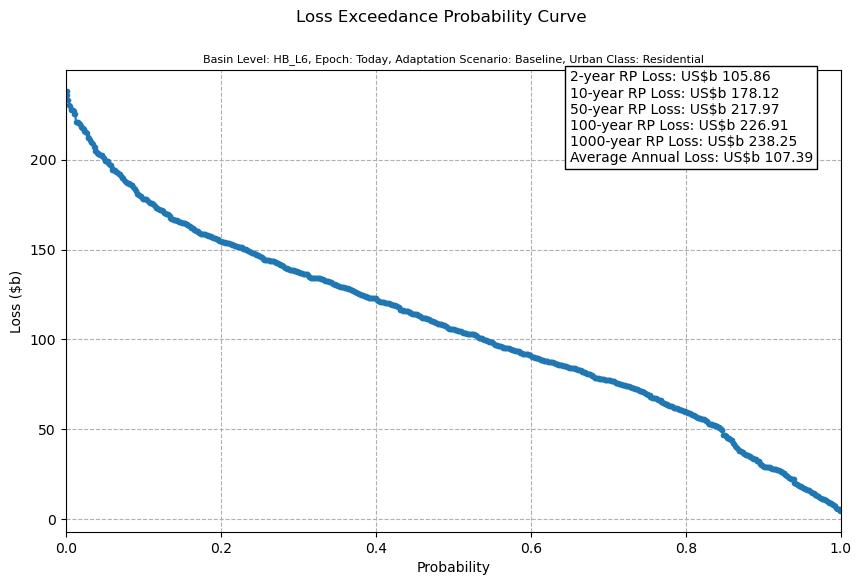

In [10]:
# Set variables for simulation
basin_level = 'HB_L6'
epoch = "Today"
adaptation_scenario = "Baseline"
urban_class = "Residential"
simulation_years = 1000
rps = [2, 10, 50, 100, 1000]
national_losses = []

# filter the risk data based on the variable specifications above
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
# Group the risk data by basin ID and AEP
group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP']).agg({'damages': 'sum'}).reset_index()

# Loop through years and simulate
for _ in range(simulation_years):

    # Calculate damages for each specified basin level based on simulated random number
    basin_damages = group_risk_data.groupby(basin_level).apply(
        lambda sub_df: interpolate_damages(sub_df, np.random.uniform(0, 1)) # simulate a random number between 0 and 1 for each basin
    )
    
    # Sum damages for national scale
    national_loss = basin_damages.sum()
    national_losses.append(national_loss)

    # Debug
    if national_loss == 0:
        print('National Loss is Zero')
    
#### Plot figures
national_losses_sorted = np.sort(national_losses)[::-1] # Sort losses in descending order
national_losses_sorted = national_losses_sorted/1000000000 # show it in billion
N = len(national_losses_sorted) # How many data points?
exceedance_probabilities = np.arange(1, N+1) / (N+1) # Calculate exceedance probabilities

# Extract RP Losses
def loss_at_rp(rp):
    aep = 1 / rp  # Annual exceedance probability
    # Approximate index in the sorted array
    idx = int(aep * N) - 1
    return national_losses_sorted[idx]

# Plot the Loss Exceedance Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probabilities, national_losses_sorted, marker='.', linestyle='-')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 1)
plt.suptitle('Loss Exceedance Probability Curve')
plt.title('Basin Level: %s, Epoch: %s, Adaptation Scenario: %s, Urban Class: %s' % (basin_level, epoch, adaptation_scenario, urban_class), fontsize=8)
plt.grid(True, which='both', ls='--')

# Inset for Return Period Losses
rp_losses_text = ""  # Initialize an empty string to accumulate loss text
for rp in rps:
    loss = loss_at_rp(rp)
    rp_losses_text += f"{rp}-year RP Loss: US$b {loss:.2f} \n"
# Average Annual Loss
aal = national_losses_sorted.mean()
rp_losses_text += f"Average Annual Loss: US$b {aal:.2f}"

# Annotate on the plot
plt.annotate(rp_losses_text, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

#### Run for Current Protection Levels

In [ ]:
# Function to linearly interpolate between RP damages (this time considering current protection levels)
def interpolate_damages_pr(sub_df, sim_aep, basin_level):
    # # Debug
    # print(sub_df)
    # First filter damages based of simulated AEP and existing protection level
    sub_df.loc[sub_df['Pr_L_AEP'] < sim_aep, 'damages'] = 0
    # Group by basin and AEP
    group_sub = sub_df.groupby([basin_level, 'AEP']).agg({'damages': 'sum'}).reset_index()
    known_aeps = group_sub['AEP'].values
    known_damages = group_sub['damages'].values
    # Interpolate based off simulated AEP
    if sim_aep > 0.5: 
        return 0 # for RPs below 2 years we assume 0 damages
    else:
        return np.interp(sim_aep, known_aeps, known_damages)

In [ ]:
# Now let's test baseline condition under current protection levels.

# Set variables for simulation
basin_level = 'HB_L7'
epoch = "Today"
adaptation_scenario = "Baseline"
urban_class = "Combined"
simulation_years = 1000
rps = [10, 50, 100, 1000]
national_losses = []

# filter the risk data based on the variable specifications above
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
# Group the risk data by basin ID, AEP, and current protection level
group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()

# Loop through years and simulate
for _ in range(simulation_years):

    # Calculate damages for each specified basin level based on simulated random number
    basin_damages = group_risk_data.groupby(basin_level).apply(
        lambda sub_df: interpolate_damages_pr(sub_df, np.random.uniform(0, 1), basin_level) # simulate a random number between 0 and 1 for each basin
    )
    
    # Sum damages for national scale
    national_loss = basin_damages.sum()
    national_losses.append(national_loss)

#### Plot figures
national_losses_sorted = np.sort(national_losses)[::-1] # Sort losses in descending order
national_losses_sorted = national_losses_sorted/1000000000 # show it in billion
N = len(national_losses_sorted) # How many data points?
exceedance_probabilities = np.arange(1, N+1) / (N+1) # Calculate exceedance probabilities

# Extract RP Losses
def loss_at_rp(rp):
    aep = 1 / rp  # Annual exceedance probability
    # Approximate index in the sorted array
    idx = int(aep * N) - 1
    return national_losses_sorted[idx]

# Plot the Loss Exceedance Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probabilities, national_losses_sorted, marker='.', linestyle='-')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 0.8)
plt.suptitle('Loss Exceedance Probability Curve')
plt.title('Basin Level: %s, Epoch: %s, Adaptation Scenario: %s, Urban Class: %s' % (basin_level, epoch, adaptation_scenario, urban_class), fontsize=8)
plt.grid(True, which='both', ls='--')

# Inset for Return Period Losses
rp_losses_text = ""  # Initialize an empty string to accumulate loss text
for rp in rps:
    loss = loss_at_rp(rp)
    rp_losses_text += f"{rp}-year RP Loss: US$b {loss:.2f} \n"
# Average Annual Loss
aal = national_losses_sorted.mean()
rp_losses_text += f"Average Annual Loss: US$b {aal:.2f}"

# Annotate on the plot
plt.annotate(rp_losses_text, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

#### Run for Idealized Protection Levels 100 RP (no urban distinction)

In [ ]:
# Function to linearly interpolate between RP damages
def interpolate_damages_100(sub_df, sim_aep):
    known_aeps = sub_df['AEP'].values
    known_damages = sub_df['damages'].values
    # Interpolate based off simulated AEP
    if sim_aep > 0.01: 
        return 0 # for RPs below 2 years we assume 0 damages
    else:
        return np.interp(sim_aep, known_aeps, known_damages)

In [ ]:
# Set variables for simulation
basin_level = 'HB_L7'
epoch = "Today"
adaptation_scenario = "Baseline"
urban_class = "Combined"
simulation_years = 1000
rps = [10, 50, 100, 1000]
national_losses = []

# filter the risk data based on the variable specifications above
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
# Group the risk data by basin ID and AEP
group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP']).agg({'damages': 'sum'}).reset_index()

# Loop through years and simulate
for _ in range(simulation_years):

    # Calculate damages for each specified basin level based on simulated random number
    basin_damages = group_risk_data.groupby(basin_level).apply(
        lambda sub_df: interpolate_damages_100(sub_df, np.random.uniform(0, 1)) # simulate a random number between 0 and 1 for each basin
    )
    
    # Sum damages for national scale
    national_loss = basin_damages.sum()
    national_losses.append(national_loss)
    
#### Plot figures
national_losses_sorted = np.sort(national_losses)[::-1] # Sort losses in descending order
national_losses_sorted = national_losses_sorted/1000000000 # show it in billion
N = len(national_losses_sorted) # How many data points?
exceedance_probabilities = np.arange(1, N+1) / (N+1) # Calculate exceedance probabilities

# Extract RP Losses
def loss_at_rp(rp):
    aep = 1 / rp  # Annual exceedance probability
    # Approximate index in the sorted array
    idx = int(aep * N) - 1
    return national_losses_sorted[idx]

# Plot the Loss Exceedance Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probabilities, national_losses_sorted, marker='.', linestyle='-')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 0.5)
plt.suptitle('Loss Exceedance Probability Curve')
plt.title('Basin Level: %s, Epoch: %s, Adaptation Scenario: %s, Urban Class: %s' % (basin_level, epoch, adaptation_scenario, urban_class), fontsize=8)
plt.grid(True, which='both', ls='--')

# Inset for Return Period Losses
rp_losses_text = ""  # Initialize an empty string to accumulate loss text
for rp in rps:
    loss = loss_at_rp(rp)
    rp_losses_text += f"{rp}-year RP Loss: US$b {loss:.2f} \n"
# Average Annual Loss
aal = national_losses_sorted.mean()
rp_losses_text += f"Average Annual Loss: US$b {aal:.2f}"

# Annotate on the plot
plt.annotate(rp_losses_text, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

#### Run for Idealized Protection Levels 100 RP (urban distinction)

In [ ]:
# Function to linearly interpolate between RP damages
def interpolate_damages_100_ub(sub_df, adaptation_scenario, sim_aep):
    # Use baseline maps if AEP < 0.01
    if sim_aep < 0.01:
        sub_df = sub_df[sub_df['adaptation_scenario']=='Baseline']
        known_aeps = sub_df['AEP'].values
        known_damages = sub_df['damages'].values
        return np.interp(sim_aep, known_aeps, known_damages)
    elif sim_aep > 0.5:
        return 0
    else:
        # interpolate urban protection as normal
        sub_df = sub_df[sub_df['adaptation_scenario']==adaptation_scenario]
        known_aeps = sub_df['AEP'].values
        known_damages = sub_df['damages'].values
        return np.interp(sim_aep, known_aeps, known_damages)

In [ ]:
# Now let's test baseline condition under current protection levels.

# Set variables for simulation
basin_level = 'HB_L7'
epoch = "Today"
adaptation_scenario = "Urban_Protection_RP100"
urban_class = "Combined"
simulation_years = 1000
rps = [10, 50, 100, 1000]
national_losses = []

# # filter the risk data based on the variable specifications above
# filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
# # Group the risk data by basin ID, AEP, and current protection level
# group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()
# group_risk_data

# filter the risk data based on the variable specifications above
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['urban_class'] == urban_class)]
# Group the risk data by basin ID, AEP, and current protection level
group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'adaptation_scenario']).agg({'damages': 'sum'}).reset_index()

# Loop through years and simulate
for _ in range(simulation_years):

    # Calculate damages for each specified basin level based on simulated random number
    basin_damages = group_risk_data.groupby(basin_level).apply(
        lambda sub_df: interpolate_damages_100_ub(sub_df, adaptation_scenario, np.random.uniform(0, 1)) # simulate a random number between 0 and 1 for each basin
    )
    
    # Sum damages for national scale
    national_loss = basin_damages.sum()
    national_losses.append(national_loss)
    
#### Plot figures
national_losses_sorted = np.sort(national_losses)[::-1] # Sort losses in descending order
national_losses_sorted = national_losses_sorted/1000000000 # show it in billion
N = len(national_losses_sorted) # How many data points?
exceedance_probabilities = np.arange(1, N+1) / (N+1) # Calculate exceedance probabilities

# Extract RP Losses
def loss_at_rp(rp):
    aep = 1 / rp  # Annual exceedance probability
    # Approximate index in the sorted array
    idx = int(aep * N) - 1
    return national_losses_sorted[idx]

# Plot the Loss Exceedance Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probabilities, national_losses_sorted, marker='.', linestyle='-')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 0.8)
plt.suptitle('Loss Exceedance Probability Curve')
plt.title('Basin Level: %s, Epoch: %s, Adaptation Scenario: %s, Urban Class: %s' % (basin_level, epoch, adaptation_scenario, urban_class), fontsize=8)
plt.grid(True, which='both', ls='--')

# Inset for Return Period Losses
rp_losses_text = ""  # Initialize an empty string to accumulate loss text
for rp in rps:
    loss = loss_at_rp(rp)
    rp_losses_text += f"{rp}-year RP Loss: US$b {loss:.2f} \n"
# Average Annual Loss
aal = national_losses_sorted.mean()
rp_losses_text += f"Average Annual Loss: US$b {aal:.2f}"

# Annotate on the plot
plt.annotate(rp_losses_text, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

#### Run for DryProofing

In [ ]:
# Now let's test baseline condition under current protection levels.

# Set variables for simulation
basin_level = 'HB_L7'
epoch = "Today"
adaptation_scenario = "Dry_Proofing"
urban_class = "Combined"
simulation_years = 1000
rps = [10, 50, 100, 1000]
national_losses = []

# filter the risk data based on the variable specifications above
filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
# Group the risk data by basin ID, AEP, and current protection level
group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()
group_risk_data

# Loop through years and simulate
for _ in range(simulation_years):

    # Calculate damages for each specified basin level based on simulated random number
    basin_damages = group_risk_data.groupby(basin_level).apply(
        lambda sub_df: interpolate_damages_pr(sub_df, np.random.uniform(0, 1), basin_level) # simulate a random number between 0 and 1 for each basin
    )
    
    # Sum damages for national scale
    national_loss = basin_damages.sum()
    national_losses.append(national_loss)
    
#### Plot figures
national_losses_sorted = np.sort(national_losses)[::-1] # Sort losses in descending order
national_losses_sorted = national_losses_sorted/1000000000 # show it in billion
N = len(national_losses_sorted) # How many data points?
exceedance_probabilities = np.arange(1, N+1) / (N+1) # Calculate exceedance probabilities

# Extract RP Losses
def loss_at_rp(rp):
    aep = 1 / rp  # Annual exceedance probability
    # Approximate index in the sorted array
    idx = int(aep * N) - 1
    return national_losses_sorted[idx]

# Plot the Loss Exceedance Probability Curve
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probabilities, national_losses_sorted, marker='.', linestyle='-')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 0.8)
plt.suptitle('Loss Exceedance Probability Curve')
plt.title('Basin Level: %s, Epoch: %s, Adaptation Scenario: %s, Urban Class: %s' % (basin_level, epoch, adaptation_scenario, urban_class), fontsize=8)
plt.grid(True, which='both', ls='--')

# Inset for Return Period Losses
rp_losses_text = ""  # Initialize an empty string to accumulate loss text
for rp in rps:
    loss = loss_at_rp(rp)
    rp_losses_text += f"{rp}-year RP Loss: US$b {loss:.2f} \n"
# Average Annual Loss
aal = national_losses_sorted.mean()
rp_losses_text += f"Average Annual Loss: US$b {aal:.2f}"

# Annotate on the plot
plt.annotate(rp_losses_text, xy=(0.65, 0.8), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

#### Script to run Monte Carlo Simulations on all scenarios

In [ ]:
# # Function to map simulated AEPs to basin IDs
# # Create function that will do interpolation on all possible scenarios

# def interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, protection_threshold, basin_level, baseline=False):
    
#     # Burn simulated aep onto sub_df
#     def map_probability(row):
#         # need to do this with a function
#         basin_id = row[basin_level]
#         if basin_id in simulated_aeps[basin_level]:
#             # if BASINID found return probability for year
#             return simulated_aeps[basin_level][basin_id][year]
#         else:
#             print('ERROR: no probability found')
#             return pd.NA

#     # Map simulated probabilities onto sub_df
#     sub_df['sim_aep'] = sub_df.apply(map_probability, axis=1)
#     # Extract simulated probability for interpolation
#     sim_aep = max(sub_df['sim_aep'])

#     # Here we will interpolate adaptation scenarios that consider the baseline protection level
#     # These scenarios include: Urban_Protection_RP100, Baseline, Dry-Proofing, and Relocation,
#     if baseline:
#         # This adaptation scenario considers only urban areas are protected to the given RP. For the interpolation we use Baseline maps
#         # for extreme probabilities. This ensures that when interpolating between 100 - 200 RP that we don't introduce additional protection
#         # i.e. if there is a 101 year flood we assume protection is breached completely and risk is maxed out rather than interpolating between
#         # 100 year protected risk and 200 year protected risk. This allows us to compare with the complete protection scenario. Also have now
#         # included that it must consider baseline protection (otherwise it may lead to higher damages than baseline damages). 
#         if adaptation_scenario == "Urban_Protection_RP100":
#                 # Use baseline maps if AEP < 0.01
#             if sim_aep < 0.01:
#                 sub_df = sub_df[sub_df['adaptation_scenario']=='Baseline']
#                 known_aeps = sub_df['AEP'].values
#                 known_damages = sub_df['damages'].values
#                 return np.interp(sim_aep, known_aeps, known_damages)
#             elif sim_aep > protection_threshold:
#                 return 0
#             else:
#                 sub_df = sub_df[sub_df['adaptation_scenario']==adaptation_scenario]
#                 sub_df['damages'] = np.where(sub_df['sim_aep'] > sub_df['Pr_L_AEP'], 0, sub_df['damages'])
#                  # Group by basin and AEP
#                 group_sub = sub_df.groupby([basin_level, 'AEP', 'sim_aep']).agg({'damages': 'sum'}).reset_index()
#                 known_aeps = group_sub['AEP'].values
#                 known_damages = group_sub['damages'].values
#                 return np.interp(sim_aep, known_aeps, known_damages)
        
#         sub_df['damages'] = np.where(sub_df['sim_aep'] > sub_df['Pr_L_AEP'], 0, sub_df['damages'])
#         # Group by basin and AEP
#         group_sub = sub_df.groupby([basin_level, 'AEP', 'sim_aep']).agg({'damages': 'sum'}).reset_index()
#         known_aeps = group_sub['AEP'].values
#         known_damages = group_sub['damages'].values
        
#         # Interpolate based off simulated AEP
#         if sim_aep > protection_threshold: 
#             return 0 # for RPs below specified protection threshold return 0 damage.
#         else:
#             return np.interp(sim_aep, known_aeps, known_damages)

#     # All other adaptation scenarios do not need to consider baseline protection levels
#     else:    
#         # Complete urban protection
#         known_aeps = sub_df['AEP'].values
#         known_damages = sub_df['damages'].values

#         # Interpolate based off simulated AEP
#         if sim_aep > protection_threshold: 
#             return 0 # for RPs below specified protection threshold return 0 damage.
#         else:
#             return np.interp(sim_aep, known_aeps, known_damages)

In [7]:
# Function to map simulated AEPs to basin IDs
# Create function that will do interpolation on all possible scenarios

def interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, protection_threshold, basin_level):
    
    # Burn simulated aep onto sub_df
    def map_probability(row):
        # need to do this with a function
        basin_id = row[basin_level]
        if basin_id in simulated_aeps[basin_level]:
            # if BASINID found return probability for year
            return simulated_aeps[basin_level][basin_id][year]
        else:
            print('ERROR: no probability found')
            return pd.NA

    # Map simulated probabilities onto sub_df
    sub_df['sim_aep'] = sub_df.apply(map_probability, axis=1)
    # Extract simulated probability for interpolation
    sim_aep = max(sub_df['sim_aep'])
    
    # This adaptation scenario considers only urban areas are protected to the given RP. For the interpolation we use Baseline maps
    # for extreme probabilities. This ensures that when interpolating between 100 - 200 RP that we don't introduce additional protection
    # i.e. if there is a 101 year flood we assume protection is breached completely and risk is maxed out rather than interpolating between
    # 100 year protected risk and 200 year protected risk. This allows us to compare with the complete protection scenario. Also have now
    # included that it must consider baseline protection (otherwise it may lead to higher damages than baseline damages). 
    if adaptation_scenario == "Urban_Protection_RP100":
            # Use baseline maps if AEP < 0.01
        if sim_aep < 0.01:
            sub_df = sub_df[sub_df['adaptation_scenario']=='Baseline']
            sub_df['damages'] = np.where(sub_df['sim_aep'] > sub_df['Pr_L_AEP'], 0, sub_df['damages'])
            # Group by basin and AEP
            group_sub = sub_df.groupby([basin_level, 'AEP', 'sim_aep']).agg({'damages': 'sum'}).reset_index()
            known_aeps = group_sub['AEP'].values
            known_damages = group_sub['damages'].values
            return np.interp(sim_aep, known_aeps, known_damages)
        elif sim_aep > protection_threshold:
            return 0
        else:
            sub_df = sub_df[sub_df['adaptation_scenario']==adaptation_scenario]
            sub_df['damages'] = np.where(sub_df['sim_aep'] > sub_df['Pr_L_AEP'], 0, sub_df['damages'])
             # Group by basin and AEP
            group_sub = sub_df.groupby([basin_level, 'AEP', 'sim_aep']).agg({'damages': 'sum'}).reset_index()
            known_aeps = group_sub['AEP'].values
            known_damages = group_sub['damages'].values
            return np.interp(sim_aep, known_aeps, known_damages)
    
    sub_df['damages'] = np.where(sub_df['sim_aep'] > sub_df['Pr_L_AEP'], 0, sub_df['damages'])
    # Group by basin and AEP
    group_sub = sub_df.groupby([basin_level, 'AEP', 'sim_aep']).agg({'damages': 'sum'}).reset_index()
    known_aeps = group_sub['AEP'].values
    known_damages = group_sub['damages'].values
    
    # Interpolate based off simulated AEP
    if sim_aep > protection_threshold: 
        return 0 # for RPs below specified protection threshold return 0 damage.
    else:
        return np.interp(sim_aep, known_aeps, known_damages)

In [8]:
# Set variables for simulation
# Set all possible variable information
simulation_years = 1000
# basin_levels = ['HB_L4', 'HB_L5', 'HB_L6', 'HB_L7']
basin_levels = ['HB_L7']
epochs = ['Today']
# epochs = ['Today', 'Future_High_Emission', 'Future_Low_Emission']
# adaptation_scenarios = ['Baseline']
adaptation_scenarios = ['Baseline', 'Dry_Proofing', 'Urban_Protection_RP100', 'Protection_RP100', 'Relocation']
# urban_classes = ['Residential', 'Non-Residential', 'Combined']
urban_classes = ['Combined']


# Step 1: Presimulate random numbers for Monte Carlo simulation
simulated_aeps = {}
for basin_level in basin_levels:
    basin_ids = risk_data[basin_level].unique()
    simulated_aeps[basin_level] = {basin_id: np.random.uniform(0, 1, simulation_years) for basin_id in basin_ids}
    
# Step 2: Loop through all variable options and calculate losses
# Results dictionary
results = {}

i = 0

for basin_level in basin_levels:
    for epoch in epochs:
        for adaptation_scenario in adaptation_scenarios:
            for urban_class in urban_classes:

                # # Debug
                # if epoch == "Today" and adaptation_scenario != "Baseline":
                #     continue
                # if adaptation_scenario != "Baseline" and epoch != "Future_High_Emission":
                #     continue
                
                if i % 1 == 0:
                    print('working on', epoch, adaptation_scenario)
                i += 1
                # Results list
                national_losses = []
                # Filter the risk data based on the variables specified in the loop
                if adaptation_scenario == "Protection_RP100":
                    # Doesn't have it's own column... user baseline
                    filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == "Baseline") & (risk_data['urban_class'] == urban_class)]
                    # Don't need current protection levels if we are assuming 100 year protection everywhere
                    group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()
                elif adaptation_scenario == "Urban_Protection_RP100":
                    # Going to send multiple different adaptation scenarios to the function. Because we pull from baseline maps for extreme risk
                    filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['urban_class'] == urban_class)]
                    # Group the risk data by basin ID, AEP, and current protection level
                    group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'adaptation_scenario', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()
                else:
                    filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
                    group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()

                # Loop through years
                for year in range(simulation_years):

                    # Calculate damages for all basins with specific variable specifications
                    if adaptation_scenario == "Protection_RP100":
                        # Assume everywhere has 100 year protection
                        basin_damages = group_risk_data.groupby(basin_level).apply(
                            lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.01, basin_level))
                    elif adaptation_scenario == "Urban_Protection_RP100":
                        basin_damages = group_risk_data.groupby(basin_level).apply(
                            lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.5, basin_level) 
                        )
                    else:
                        basin_damages = group_risk_data.groupby(basin_level).apply(
                            lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.5, basin_level))
                    
                    national_loss = basin_damages.sum()
                    national_losses.append(national_loss)

                results["{}_{}_{}_{}".format(basin_level, epoch, adaptation_scenario, urban_class)] = national_losses

working on Today Baseline
working on Today Dry_Proofing
working on Today Urban_Protection_RP100
working on Today Protection_RP100
working on Today Relocation


In [146]:
# # Set variables for simulation
# # Set all possible variable information
# simulation_years = 10
# # basin_levels = ['HB_L4', 'HB_L5', 'HB_L6', 'HB_L7']
# basin_levels = ['HB_L7']
# # epochs = ['Today']
# epochs = ['Today', 'Future_High_Emission', 'Future_Low_Emission']
# adaptation_scenarios = ['Baseline', 'Dry_Proofing', 'Urban_Protection_RP100', 'Protection_RP100', 'Relocation']
# # urban_classes = ['Residential', 'Non-Residential', 'Combined']
# urban_classes = ['Combined']


# # Step 1: Presimulate random numbers for Monte Carlo simulation
# simulated_aeps = {}
# for basin_level in basin_levels:
#     basin_ids = risk_data[basin_level].unique()
#     simulated_aeps[basin_level] = {basin_id: np.random.uniform(0, 1, simulation_years) for basin_id in basin_ids}
    
# # Step 2: Loop through all variable options and calculate losses
# # Results dictionary
# results = {}

# i = 0

# for basin_level in basin_levels:
#     for epoch in epochs:
#         for adaptation_scenario in adaptation_scenarios:
#             for urban_class in urban_classes:
#                 if i % 1 == 0:
#                     print('working on', epoch, adaptation_scenario)
#                 i += 1
#                 # Results list
#                 national_losses = []
#                 # Filter the risk data based on the variables specified in the loop
#                 if adaptation_scenario == "Protection_RP100":
#                     # Doesn't have it's own column... user baseline
#                     filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == "Baseline") & (risk_data['urban_class'] == urban_class)]
#                     # Don't need current protection levels if we are assuming 100 year protection everywhere
#                     group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP']).agg({'damages': 'sum'}).reset_index()
#                 elif adaptation_scenario == "Urban_Protection_RP100":
#                     # Going to send multiple different adaptation scenarios to the function. Because we pull from baseline maps for extreme risk
#                     filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['urban_class'] == urban_class)]
#                     # Group the risk data by basin ID, AEP, and current protection level
#                     group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'adaptation_scenario', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()
#                 else:
#                     filtered_risk_data = risk_data[(risk_data['epoch'] == epoch) & (risk_data['adaptation_scenario'] == adaptation_scenario) & (risk_data['urban_class'] == urban_class)]
#                     group_risk_data = filtered_risk_data.groupby([basin_level, 'AEP', 'Pr_L_AEP']).agg({'damages': 'sum'}).reset_index()

#                 # Loop through years
#                 for year in range(simulation_years):

#                     # Calculate damages for all basins with specific variable specifications
#                     if adaptation_scenario == "Protection_RP100":
#                         # Assume everywhere has 100 year protection
#                         basin_damages = group_risk_data.groupby(basin_level).apply(
#                             lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.01, basin_level))
#                     elif adaptation_scenario == "Urban_Protection_RP100":
#                         basin_damages = group_risk_data.groupby(basin_level).apply(
#                             lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.5, basin_level, baseline=True) 
#                         )
#                     else:
#                         basin_damages = group_risk_data.groupby(basin_level).apply(
#                             lambda sub_df: interpolate_damages_all(sub_df, simulated_aeps, adaptation_scenario, year, 0.5, basin_level, baseline=True))
                    
#                     national_loss = basin_damages.sum()
#                     national_losses.append(national_loss)

#                 results["{}_{}_{}_{}".format(basin_level, epoch, adaptation_scenario, urban_class)] = national_losses

In [145]:
# # Debug
# print(np.sort(results['HB_L7_Future_High_Emission_Protection_RP100_Combined'][::-1]))
# print(np.sort(results['HB_L7_Future_High_Emission_Urban_Protection_RP100_Combined'][::-1]))

In [9]:
# Save this dictionry so we don't have to run it again
import pickle

# Saving the dictionary to a file using pickle
with open(r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\simulation_10000_results.pkl", 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

### PLOT THIS BABY

In [25]:
results

{'HB_L7_Today_Baseline_Combined': [2562480177.7017407,
  17139772671.688648,
  7388845685.580083,
  4092799627.580097,
  5069825869.55019,
  4012146822.784684,
  2168524677.6216764,
  5088663153.599754,
  2075616853.828097,
  1723383639.5315742,
  430080640.3311486,
  4038270927.441666,
  5943250106.252188,
  3529991386.1217046,
  66824709167.446655,
  105688072031.95236,
  2054022118.395144,
  14580749232.859638,
  2484763138.6225057,
  3781852572.4152136,
  2606881386.5617156,
  1465188161.4707355,
  16930320809.020786,
  1529436299.3199189,
  3101281679.314641,
  1370992614.504437,
  1750298172.2848387,
  1323622095.493717,
  9005476150.68199,
  1953451290.279406,
  2105998570.4390693,
  3288124580.9453106,
  1789339018.4382925,
  4464075855.751569,
  3794174416.421522,
  3477106451.4050636,
  1615613614.3023953,
  20410972073.33995,
  5399513758.512666,
  1009828791.6307774,
  2684973821.4472914,
  357410715.58021986,
  4998939829.367886,
  4506877944.265321,
  3665600228.671508,
 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

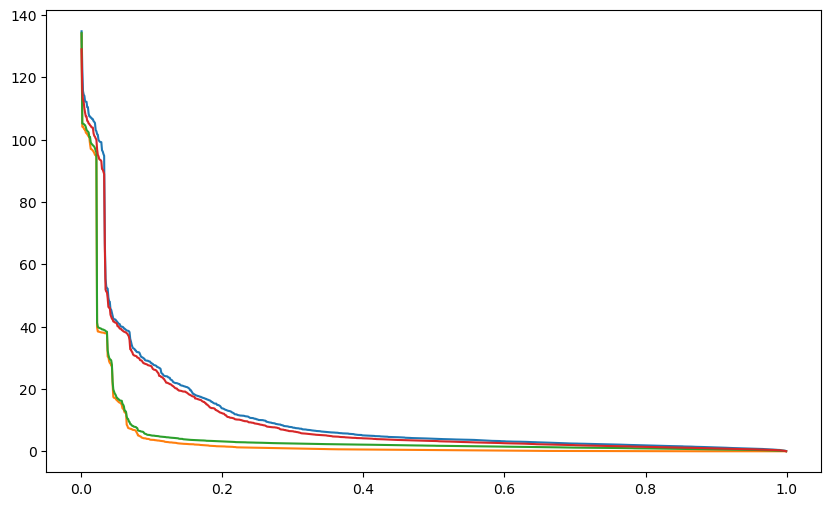

In [24]:
# Function to calculate exceedance probabilities
def calculate_exceedance_probabilities(losses):
    sorted_losses = sorted(losses, reverse=True)
    N = len(sorted_losses)
    exceedance_probabilities = [(i+1) / (N+1) for i in range(N)]
    return exceedance_probabilities, sorted_losses

def calculate_rp_and_aal(losses):
    # Sort losses in descending order
    sorted_losses = sorted(losses, reverse=True)
    N = len(sorted_losses)
    
    # Calculate exceedance probabilities
    exceedance_probabilities = [(i+1) / (N+1) for i in range(N)]
    
    # Find the loss corresponding to the 100-year return period (RP = 100 years)
    rp_10_index = np.searchsorted(exceedance_probabilities, 0.1, side='right') - 1
    rp_10_loss = sorted_losses[rp_10_index] if rp_10_index < N else None
    rp_50_index = np.searchsorted(exceedance_probabilities, 0.05, side='right') - 1
    rp_50_loss = sorted_losses[rp_50_index] if rp_50_index < N else None
    rp_100_index = np.searchsorted(exceedance_probabilities, 0.01, side='right') - 1
    rp_100_loss = sorted_losses[rp_100_index] if rp_100_index < N else None
    rp_200_index = np.searchsorted(exceedance_probabilities, 0.005, side='right') - 1
    rp_200_loss = sorted_losses[rp_200_index] if rp_200_index < N else None
    rp_500_index = np.searchsorted(exceedance_probabilities, 0.002, side='right') - 1
    rp_500_loss = sorted_losses[rp_500_index] if rp_500_index < N else None
    rp_1000_index = np.searchsorted(exceedance_probabilities, 0.001, side='right') - 1
    rp_1000_loss = sorted_losses[rp_1000_index] if rp_1000_index < N else None
    
    # Calculate average annual loss (AAL)
    aal = np.mean(losses)
    
    return rp_10_loss, rp_50_loss, rp_100_loss, rp_200_loss, rp_500_loss, rp_1000_loss, aal
    

# Example plotting function
def plot_loss_probability_curves(results, scenarios_to_plot):
    plt.figure(figsize=(10, 6))

    RP_and_AAL = {} # dictioinary to save RP100 and AAL for printing 
    
    for scenario in scenarios_to_plot:
        if scenario in results:
            losses = results[scenario]
            losses = [i/1000000000 for i in losses]
            rp_10, rp_50, rp_100, rp_200, rp_500, rp_1000, aal = calculate_rp_and_aal(losses)
            RP_and_AAL[scenario] = [rp_10, rp_50, rp_100, rp_200, rp_500, rp_1000, aal]
            exceedance_probabilities, sorted_losses = calculate_exceedance_probabilities(losses)
            label = scenario_labels.get(scenario, scenario)  # Use custom label if provided, else use scenario name
            plt.plot(exceedance_probabilities, sorted_losses, label=label)
    
    plt.xlabel('Probability')
    plt.ylabel('Losses (US$b)')
    plt.xlim(0, 0.5)
    plt.title('Loss-Probability Curves')
    plt.legend()
    plt.grid(True, which='both', ls='--')
    # plt.yscale('log')  # Optional: Log scale for better visualization of wide-ranging data
    plt.show()

    # Print RP and AAL for each scenario
    for scenario, list in RP_and_AAL.items():
        label = scenario_labels.get(scenario, scenario)  # Use custom label if provided
        print(f"{label}")
        print(f"10-Year RP Loss = {list[0]:.2f} Billion")
        print(f"50-Year RP Loss = {list[1]:.2f} Billion")
        print(f"100-Year RP Loss = {list[2]:.2f} Billion")
        print(f"200-Year RP Loss = {list[3]:.2f} Billion")
        print(f"500-Year RP Loss = {list[4]:.2f} Billion")
        print(f"1000-Year RP Loss = {list[5]:.2f} Billion")
        print(f"AAL = {list[-1]:.2f} Billion")

# Specify the scenarios you want to plot
# scenarios_to_plot = ['HB_L7_Future_High_Emission_Baseline_Combined', 'HB_L7_Future_High_Emission_Protection_RP100_Combined', 
#                      'HB_L7_Future_High_Emission_Urban_Protection_RP100_Combined', 'HB_L7_Future_High_Emission_Dry_Proofing_Combined',
#                     'HB_L7_Future_High_Emission_Relocation_Combined']  # Add more as needed

scenarios_to_plot = ['HB_L7_Today_Baseline_Combined', 'HB_L7_Today_Protection_RP100_Combined',
                     'HB_L7_Today_Urban_Protection_RP100_Combined','HB_L7_Today_Dry_Proofing_Combined',
                    'HB_L7_Today_Relocation_Combined']

scenario_labels = {'HB_L7_Today_Baseline_Combined': 'Scenario 1',
                  'HB_L7_Today_Protection_RP100_Combined': 'Scenario 2',
                  'HB_L7_Today_Urban_Protection_RP100_Combined': 'Scenario 3',
                  'HB_L7_Today_Dry_Proofing_Combined': 'Scenario 4',
                  'HB_L7_Today_Relocation_Combined': 'Scenario 5'}


# scenario_labels = {'HB_L7_Future_High_Emission_Baseline_Combined': 'Scenario 1: Baseline',
#                   'HB_L7_Future_High_Emission_Protection_RP100_Combined': 'Scenario 2: 100-year Protection Everywhere',
#                    'HB_L7_Future_High_Emission_Urban_Protection_RP100_Combined': 'Scenario 3: 100-year Protection in Urbanized Areas',
#                   'HB_L7_Future_High_Emission_Dry_Proofing_Combined': 'Scenario 4: Dry Proofing of Buildings',
#                   'HB_L7_Future_High_Emission_Relocation_Combined': 'Scenario 5: Relocation of Buildings'}

# Plotting
plot_loss_probability_curves(results, scenarios_to_plot)

In [55]:
print(np.sort(results['HB_L7_Today_Baseline_Combined'][::-1]))

[7.47750580e+07 2.76464240e+08 2.79851905e+08 2.86232734e+08
 2.93465897e+08 3.32416252e+08 3.46699603e+08 3.69892873e+08
 4.32637386e+08 4.48174386e+08 4.83438099e+08 4.87054910e+08
 4.90675377e+08 5.00166329e+08 5.41120022e+08 5.47412051e+08
 5.51944906e+08 5.99843995e+08 6.13164974e+08 6.16451882e+08
 6.20175728e+08 6.20677308e+08 6.27186839e+08 6.28517343e+08
 6.43714256e+08 6.47051400e+08 6.48131124e+08 6.76853798e+08
 6.82171846e+08 6.84342848e+08 6.94402718e+08 7.04992289e+08
 7.06047415e+08 7.13887637e+08 7.37863119e+08 7.57423494e+08
 7.87373279e+08 8.16910500e+08 8.17835047e+08 8.22336508e+08
 8.25825706e+08 8.41568827e+08 8.44202249e+08 8.55602367e+08
 8.62452959e+08 8.67591848e+08 8.68471375e+08 8.68751263e+08
 8.71615787e+08 8.74441305e+08 8.77578598e+08 8.84409498e+08
 8.87811191e+08 9.05377663e+08 9.50812976e+08 9.53286096e+08
 9.69954903e+08 9.74047028e+08 9.80710992e+08 9.82585248e+08
 9.87939124e+08 1.00985558e+09 1.01752256e+09 1.02160483e+09
 1.02727929e+09 1.029336